## Libraries Used

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

The dataset we are using is of banknote authentication Data Set which is extracted from images. 
For this you have to download the csv that I have in my repository and load it into pandas dataframe

In [ ]:
df = pd.read_csv("C:/Users/chand/Downloads/data_banknote_authentication.txt",header = None)

In [4]:
df.shape

(1372, 5)

In [6]:
df.columns = ["variance","skewness","curtosis","entropy_of_image","class"]

In [24]:
df.head(10)

,variance,skewness,curtosis,entropy_of_image,class
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


In [19]:
df.index

RangeIndex(start=0, stop=1372, step=1)

Random shuffling the data as all the classes with 0 outocome is clustered together.

In [28]:
df = df.reindex(np.random.permutation(df.index))

In [32]:
df.head()

,variance,skewness,curtosis,entropy_of_image,class
505,2.56500,8.6330,-2.99410,-1.308200,0
745,0.75736,3.0294,2.91640,-0.068117,0
995,-2.12340,1.1815,-0.55552,-0.811650,1
375,0.58836,10.7727,-1.38840,-4.327600,0
401,2.21230,-5.8395,7.76870,-0.853020,0


## Basic EDA

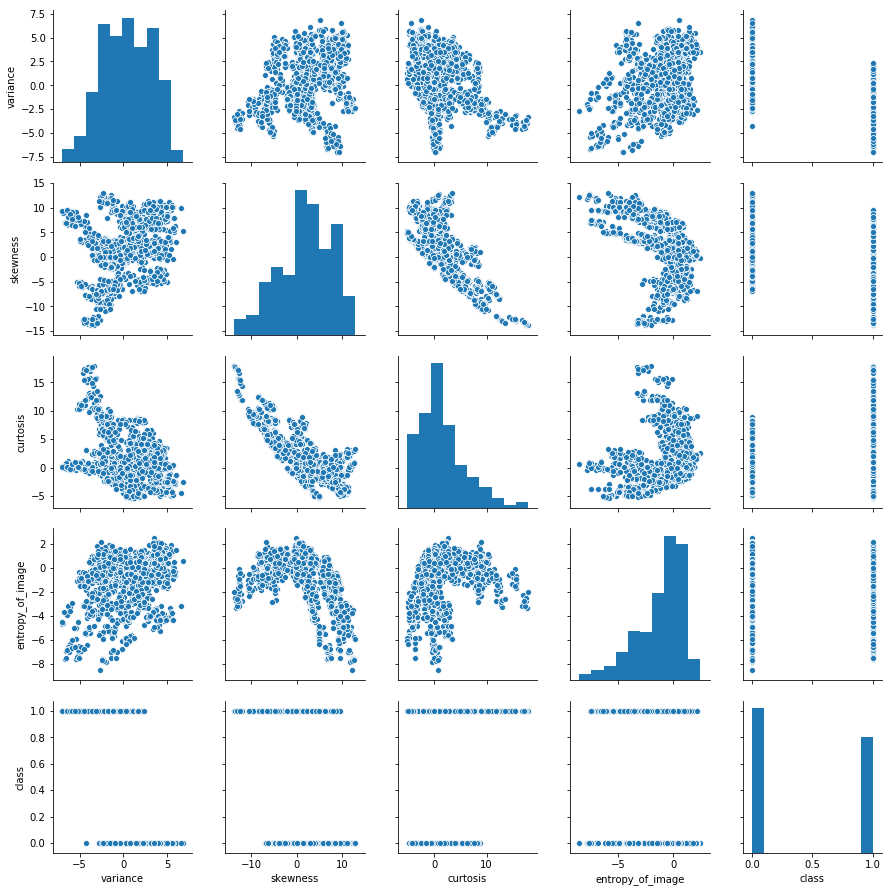

In [34]:
sns.pairplot(df)

## Building custom estimator

In [122]:
## Splitting Dataset
x = df[["variance","skewness","curtosis","entropy_of_image"]].values
y = df["class"].values

In [123]:
## Creating test and train split of data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.3)

First we will create a custom estimator for binary classification with the Logistic Regression model from sklearn

In [157]:
## Custom Estimator for Logistic regression
import numpy as np

from sklearn.base import ClassifierMixin, BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


class custom_estimator(BaseEstimator, ClassifierMixin):  # 1
    def __init__(self, estimator=LogisticRegression(), null_strategy='median'):  # 2
        self.estimator = estimator
        self.null_strategy = null_strategy
        
    def fit(self, X, y):
        # Optional: insert logic to configure our pipeline based on properties of X
        self.fitted_estimator_ = self.estimator.fit(X, y)
        return self

    def predict(self, X):
        return self.fitted_estimator_.predict(X)

Now we will create an optimization class which will optimize our score based upon gini coefficient.  
We know that gini score = 2*roc_auc_score - 1  
So, to optimize this score we need to optimize the threshold for roc_auc curve which will optimize our score

In [158]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
class ThresholdBinarizer(BaseEstimator,TransformerMixin):
    def __init__(self, estimator = LogisticRegression()):
        self.estimator = estimator
    def fit(self, X, y):
        # Optional: insert logic to configure our pipeline based on properties of X
        self.fitted_estimator_ = self.estimator.fit(X, y)
        return self
    def threshold(self,X,y):
        self.prediction_=  self.fitted_estimator_.predict_proba(X)[:,1]
        self.fpr, self.tpr, self.thresholds = roc_curve(y, self.prediction_)
        self.accuracy_scores = []
        for thresh in self.thresholds:
            self.accuracy_scores.append(accuracy_score(y, 
                                         [1 if m > thresh else 0 for m in self.prediction_]))

        self.accuracies = np.array(self.accuracy_scores)
        self.max_accuracy = self.accuracies.max() 
        self.max_accuracy_threshold =  self.thresholds[self.accuracies.argmax()]
        return self.max_accuracy_threshold
    def gini_coeff(self, X,y):
        self.prediction_=  self.fitted_estimator_.predict_proba(X)[:,1]
        self.gini = (2*roc_auc_score(y,
                                     [1 if m > self.max_accuracy_threshold else 0 for m in self.prediction_]))-1
        return self.gini

## Train and testing our model

In [159]:
## let us first test our base model
first_est = custom_estimator()
first_est.fit(x_train,y_train)

C:\Users\chand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


custom_estimator(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
         null_strategy='median')

In [160]:
first_est.predict(x_test)

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,

In [161]:
## Computing gini score
from sklearn.metrics import roc_auc_score
print("Gini Score is : ",(2*roc_auc_score(y_test,first_est.predict(x_test)))-1)

Gini Score is :  0.9816478315464117


In [162]:
## Finding optimal threshold
opt_thres = ThresholdBinarizer()
opt_thres.fit(x_train,y_train)


C:\Users\chand\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ThresholdBinarizer(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))

In [167]:
# Optimal Threshold for probability to be 1
opt_thres.threshold(x_test,y_test)

0.7987427204256301

In [166]:
# New Gini Coefficient
opt_thres.gini_coeff(x_test,y_test)

0.9885057471264367

As we can see our ginni coefficient is increased by a little margin on finding the optimal threshold value.

There is a slight increase in performance of our model

## Thank You